# Detecting Potholes in the Wild

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import random_split

In [2]:
data_path = 'Potholes/annotated-images'

In [3]:
 # Replace this with your folder path
# List all files and directories in the specified folder
contents = os.listdir(data_path)

# Print the list of contents
#print("Contents of the folder:")
#for item in contents:
#    print(item)

In [4]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax-xmin, ymax-ymin]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [5]:
class PhC(torch.utils.data.Dataset):
    def __init__(self, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        self.image_paths = sorted(glob.glob(data_path + '/*.jpg'))
        self.box_paths = sorted(glob.glob(data_path + '/*.xml'))
    
    def __len__(self):
        'Returns the total number of samples'
        return len(self.box_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        box_path = self.box_paths[idx]

        image = Image.open(image_path)
        im_name, box = read_content(box_path)
        Y = torch.tensor(box)
        X = self.transform(image)
        
        return X, Y



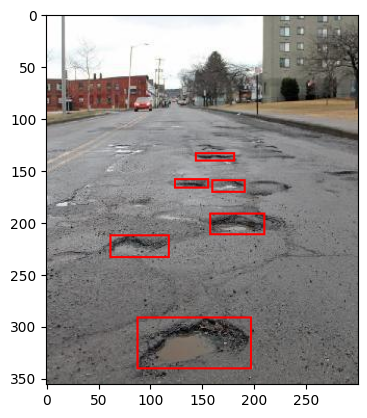

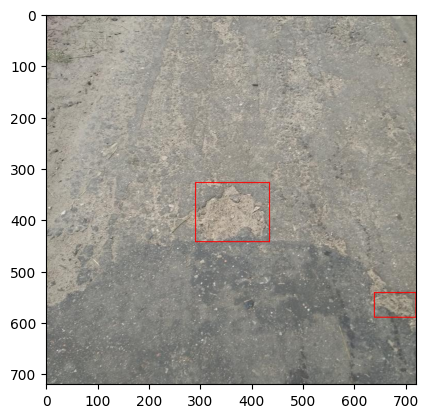

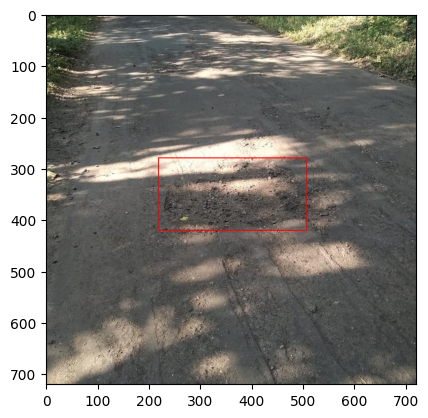

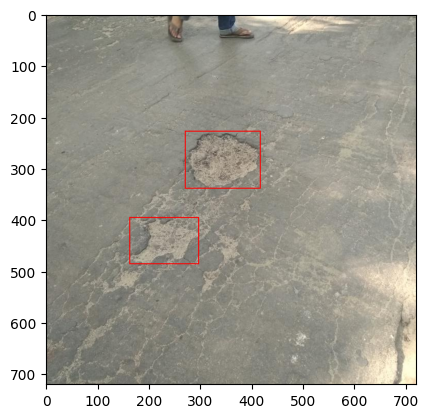

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


size = 128
# Define the transform with resizing and center cropping
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create PH2 dataset
dataset = PhC(transform=train_transform, data_path=data_path)

# Custom collate function
def my_collate(batch):
    images, boxes = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, boxes

# Create data loader with custom collate function
batch_size = 1
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3, collate_fn=my_collate)

# Set the maximum number of images to display
max_images_to_display = 4

# Counter for displayed images
displayed_images = 0

# Iterate over the DataLoader
for images, boxes in train_loader:
    # Convert the images to numpy arrays
    images_np = images.permute(0, 2, 3, 1).numpy()

    # Iterate over each sample in the batch
    for i in range(batch_size):
        if displayed_images >= max_images_to_display:
            break

        image_np = images_np[i]
        boxes_sample = boxes[i]

        # Create a PIL image from the numpy array
        image_pil = Image.fromarray((image_np * 255).astype('uint8'))

        # Create a draw object to draw bounding boxes on the image
        draw = ImageDraw.Draw(image_pil)

        # Iterate over each bounding box in the sample
        for box in boxes_sample:
            # Draw the bounding box on the image
            draw.rectangle([box[0], box[1], box[2]+box[0], box[3]+box[1]], outline='red', width=2)

        # Show the image with bounding boxes
        plt.imshow(image_pil)
        plt.show()

        # Increment the counter
        displayed_images += 1

    # Break out of the outer loop if the desired number of images is displayed
    if displayed_images >= max_images_to_display:
        break


In [7]:
import cv2
def selective_search(image, num_proposals, method="fast"):
    # image = cv2.imread(image_path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)

    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    selected_rects = rects[:num_proposals]
    return selected_rects

In [8]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format (x, y, width, height)

    Returns:
    - IoU score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Check for no overlap
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0

    # Calculate area of intersection and union
    area_intersection = w_intersection * h_intersection
    area_union = w1 * h1 + w2 * h2 - area_intersection

    # Calculate IoU
    iou = area_intersection / area_union

    return iou

In [9]:
def label_proposals(all_proposals, labels, max_threshold_iou=0.7, min_threshold_iuo=0.3):
    best_bbs = []
    worst_bbs = []
    for label in labels[0]:
        max_iou = max_threshold_iou
        best_bb = None
        worst_bb = None
        for proposal in all_proposals:
            iou = calculate_iou(proposal, label)
            if iou >= max_iou:
                max_iou = iou
                best_bb = proposal
            if iou < min_threshold_iuo:
                worst_bb = proposal
                if worst_bb is not None:
                    worst_bbs.append(worst_bb)
        if best_bb is not None:
            best_bbs.append(best_bb)
        
    # Ensure that len(worst_bbs) is 3 times the length of best_bbs
    target_length = len(best_bbs) * 3
    if len(worst_bbs) > target_length:
        worst_bbs = worst_bbs[:target_length]
    return best_bbs, worst_bbs

In [10]:
id = 0
images = []
labels_s = []
best_bbs_s = []
worst_bbs_s = []
for image, labels in train_loader:
    id += 1
    if id == 6:
        break
    image_np = image.squeeze().permute(1, 2, 0).numpy()
    all_proposals = selective_search(image_np, 5000, method="notsofast")
    best_bbs, worst_bbs = label_proposals(all_proposals, labels)
    best_bbs_s.append(best_bbs)
    worst_bbs_s.append(worst_bbs)
    images.append(image)
    labels_s.append(labels)

In [11]:
print(worst_bbs_s)
print(len(worst_bbs_s))
print(best_bbs_s)
print(len(best_bbs_s))

[[], [array([221, 303,  20,  17], dtype=int32), array([250, 609,  15,  21], dtype=int32), array([672, 394,  16,  12], dtype=int32)], [array([560, 476,  27,  40], dtype=int32), array([337,  42,  57,  15], dtype=int32), array([145, 127,  30,  16], dtype=int32)], [array([136, 352,   8,  16], dtype=int32), array([640,  60,  80,  30], dtype=int32), array([360, 115,  17,  17], dtype=int32), array([  0,   0, 720, 720], dtype=int32), array([672, 673,  48,  47], dtype=int32), array([341, 376,  23,  36], dtype=int32)], []]
5
[[], [array([ 82, 158, 505, 275], dtype=int32)], [array([304, 288, 159, 132], dtype=int32)], [array([  0, 190, 107,  81], dtype=int32), array([253, 351, 334, 214], dtype=int32)], []]
5


In [12]:
def clip_image(image, coordinates):
    x, y, w, h = map(int, coordinates)
    clipped_segment = transforms.functional.crop(image, x, y, h, w)

    return clipped_segment


In [34]:
# List to store cropped images and labels
cropped_background = []
cropped_labels = []
data = []
classes = []

# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Assuming best_bbs_s contains bounding box coordinates for each image
    cur_bbs = worst_bbs_s[idx]
    labels = labels_s[idx][0]
    
    # Crop and append images based on bounding boxes
    for bbs in cur_bbs:
        print(bbs)

        if len(bbs) > 0:
            # Crop the image based on bounding box coordinates
            cropped_img = clip_image(img, bbs)
    
            # Append the cropped image and labels to the list
            cropped_background.append(cropped_img)
    for label in labels:
        cropped_img = clip_image(img, label)

        # Append the cropped image and labels to the list
        cropped_labels.append(cropped_img)

data.extend(cropped_background)
data.extend(cropped_labels)

classes.extend([torch.tensor([0])]*len(cropped_background))
classes.extend([torch.tensor([1])]*len(cropped_labels))

[221 303  20  17]
[250 609  15  21]
[672 394  16  12]
[560 476  27  40]
[337  42  57  15]
[145 127  30  16]
[136 352   8  16]
[640  60  80  30]
[360 115  17  17]
[  0   0 720 720]
[672 673  48  47]
[341 376  23  36]


In [28]:
print(classes)

[tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1])]


In [29]:
# List to store test images, coordinates, and labels
test_set = []

# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Run selective search on the image
    all_proposals = selective_search(img, 2000, method="fast")

    # Store the original image and its proposals
    test_set.append({
        'image':img})

    # Crop and append images based on proposals
    for proposal in all_proposals:
        # Crop the image based on proposal coordinates
        cropped_img = clip_image(img, proposal)

        # Append the cropped image and proposals to the list
        test_set.append({
            'image': cropped_img,
            'coordinates': proposal
        })
    

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'setBaseImage'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [30]:
# Instantiate the VGG11 model with or without pretrained weights
model = models.vgg16(pretrained=True)

# Modify the classifier for your specific task
# Example: Replace the final fully connected layer for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add a dropout layer with dropout probability of 0.5
    nn.Linear(1024, 2)  # Change 2 to the number of classes in your dataset
)

# Insert batch normalization after each convolutional layer
for layer in model.classifier.children():
    if isinstance(layer, nn.Conv2d):
        model.features[model.features.index(layer)] = nn.Sequential(
            layer,
            nn.BatchNorm2d(layer.out_channels),
            nn.ReLU(inplace=True)
        )

# Set device and define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
print(data)

[tensor([[[[0.4353, 0.6588, 0.7843,  ..., 0.6941, 0.6706, 0.5294],
          [0.7255, 0.6471, 0.8118,  ..., 0.6980, 0.6784, 0.5216],
          [0.6941, 0.8078, 0.7373,  ..., 0.6784, 0.7569, 0.6510],
          ...,
          [0.7333, 0.6706, 0.7373,  ..., 0.7176, 0.7373, 0.8118],
          [0.7255, 0.5961, 0.6627,  ..., 0.6392, 0.7961, 0.8392],
          [0.7686, 0.6549, 0.5608,  ..., 0.7490, 0.7529, 0.6431]],

         [[0.3725, 0.5961, 0.7216,  ..., 0.6314, 0.6078, 0.4667],
          [0.6627, 0.5765, 0.7412,  ..., 0.6275, 0.6157, 0.4588],
          [0.6275, 0.7333, 0.6667,  ..., 0.6118, 0.6941, 0.5882],
          ...,
          [0.6745, 0.6039, 0.6706,  ..., 0.6510, 0.6706, 0.7451],
          [0.6667, 0.5294, 0.5961,  ..., 0.5725, 0.7294, 0.7725],
          [0.7098, 0.5882, 0.4941,  ..., 0.6824, 0.6863, 0.5765]],

         [[0.2431, 0.4627, 0.5882,  ..., 0.5333, 0.5176, 0.3765],
          [0.5333, 0.4353, 0.6000,  ..., 0.5333, 0.5255, 0.3686],
          [0.5098, 0.6039, 0.5255,  ..., 

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [38]:
import torch.optim as optim

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop

size = 256  # Change this to your desired size
# Define the transformation
train_transform = transforms.Compose([transforms.Resize((size, size))])
# Apply the transformation to each sample in data
resized_data = [train_transform(sample) for sample in data]
num_epochs = 10
for epoch in range(num_epochs):
    for input_data, target_data in zip(resized_data, classes):
        X_batch = input_data.to(device)
        Y_batch = target_data.to(device)
        # Forward pass
        outputs = model(X_batch)  # Assuming your model expects a batch dimension
        # Calculate the loss
        loss = criterion(outputs, Y_batch)#, dtype=torch.long)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    """
    # Validation (optional)
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            val_losses = []
            for val_idx, val_input_data in enumerate(data):
                val_outputs = model(val_input_data.unsqueeze(0))
                val_loss = criterion(val_outputs, torch.tensor([classes[val_idx]], dtype=torch.long))
                val_losses.append(val_loss.item())
            average_val_loss = sum(val_losses) / len(val_losses)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {average_val_loss:.4f}')
    """
